In [1]:
## requirements
# conda install --file env/byoml_tensorflow.environment.yml
# conda activate byoml_tensorflow 
# pip install -r env/byoml_tensorflow.requirements.txt

In [2]:
MODEL_NAME='retries-example'
WINDOW=12
TEST_DATA_SIZE = 24

## Retries example based on a TensorFlow model

In this notebook we show how you can create and upload a TensorFlow model to Waylay. We will expect you to save your model using the [SavedModel format](https://www.tensorflow.org/guide/saved_model).
When a model is uploaded to Waylay, it takes a moment to compile the model. After compilation, the model will be available for use. If a request ('get' or 'predict') is done before the model is compiled, a 409 Error will be returned. Python SDK has a standard Retry policy, but this can be configured by the user as they wish. If logging is turned on, more info on each retry will be logged.

First let's import a dataset:

In [3]:
import seaborn as sns
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO)

ModuleNotFoundError: No module named 'seaborn'

In [4]:
df = sns.load_dataset('flights')
df = df.set_index(['year', 'month'])
df.plot(figsize=(16,6))
df.unstack('month')

NameError: name 'sns' is not defined

In [5]:
import tensorflow as tf
import numpy as np

In [6]:


# features are a sliding window over the last 12 months, predicting the following month
def features_and_labels(input_df, window=WINDOW):
    feat_columns = [ f'+{i}M' for i in range(window) ]
    label_columns = [f'+{window}M']
    index = input_df.index[:len(input_df.index) - window]
    
    ds = tf.data.Dataset.from_tensor_slices(input_df['passengers'].values)
    feat_ds = ds.window(window, shift=1, drop_remainder=True).take(len(index))
    
    df_feat = pd.DataFrame(
        data=(list(w.as_numpy_iterator()) for w in feat_ds), 
        index=index, 
        columns=feat_columns
    )

    df_labels = pd.DataFrame(
        data=input_df.iloc[window:,0].values, 
        index=index, 
        columns=label_columns
    )
    
    return pd.concat([df_feat, df_labels], axis=1, keys=['features','labels'])

df_train = features_and_labels(df.iloc[:-TEST_DATA_SIZE])
display(df_train)
df_test = features_and_labels(df.iloc[-TEST_DATA_SIZE-WINDOW:])

features                                                         \
                +0M  +1M  +2M  +3M  +4M  +5M  +6M  +7M  +8M  +9M +10M +11M   
year month                                                                   
1949 Jan        112  118  132  129  121  135  148  148  136  119  104  118   
     Feb        118  132  129  121  135  148  148  136  119  104  118  115   
     Mar        132  129  121  135  148  148  136  119  104  118  115  126   
     Apr        129  121  135  148  148  136  119  104  118  115  126  141   
     May        121  135  148  148  136  119  104  118  115  126  141  135   
...             ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1957 Aug        467  404  347  305  336  340  318  362  348  363  435  491   
     Sep        404  347  305  336  340  318  362  348  363  435  491  505   
     Oct        347  305  336  340  318  362  348  363  435  491  505  404   
     Nov        305  336  340  318  362  348  363  435  491  505  404  359   
     Dec        336  340  318  362  348  363  435  491  505  404  359  310   

           labels  
             +12M  
year month         
1949 Jan      115  
     Feb      126  
     Mar      141  
     Apr      135  
     May      125  
...           ...  
1957 Aug      505  
     Sep      404  
     Oct      359  
     Nov      310  
     Dec      337  

[108 rows x 13 columns]

In [7]:
X_train = tf.convert_to_tensor(df_train.xs('features',axis=1).values)
y_train = tf.convert_to_tensor(df_train.xs('labels',axis=1).values)
X_test = tf.convert_to_tensor(df_test.xs('features',axis=1).values)
y_test = tf.convert_to_tensor(df_test.xs('labels',axis=1).values)

Now we can create the model, a simple one:

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(X_train.shape[1],), name="previous_month"))
model.add(tf.keras.layers.Reshape((X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(100))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam' , loss='mse')

In [9]:
history = model.fit(X_train, y_train,
                    batch_size=4,
                    epochs=10,
                    verbose=1)

Train on 108 samples
Epoch 1/10
108/108 [==============================] - 1s 10ms/sample - loss: 74631.4653
Epoch 2/10
108/108 [==============================] - 0s 1ms/sample - loss: 73083.7011
Epoch 3/10
108/108 [==============================] - 0s 971us/sample - loss: 70656.0453
Epoch 4/10
108/108 [==============================] - 0s 1ms/sample - loss: 68279.0922
Epoch 5/10
108/108 [==============================] - 0s 948us/sample - loss: 66537.4433
Epoch 6/10
108/108 [==============================] - 0s 978us/sample - loss: 65179.4780
Epoch 7/10
108/108 [==============================] - 0s 958us/sample - loss: 63847.1635
Epoch 8/10
108/108 [==============================] - 0s 1ms/sample - loss: 62693.3294
Epoch 9/10
108/108 [==============================] - 0s 1ms/sample - loss: 61622.8995
Epoch 10/10
108/108 [==============================] - 0s 1ms/sample - loss: 60589.2310


Let's validate if the model learned something:

<AxesSubplot:xlabel='year,month'>

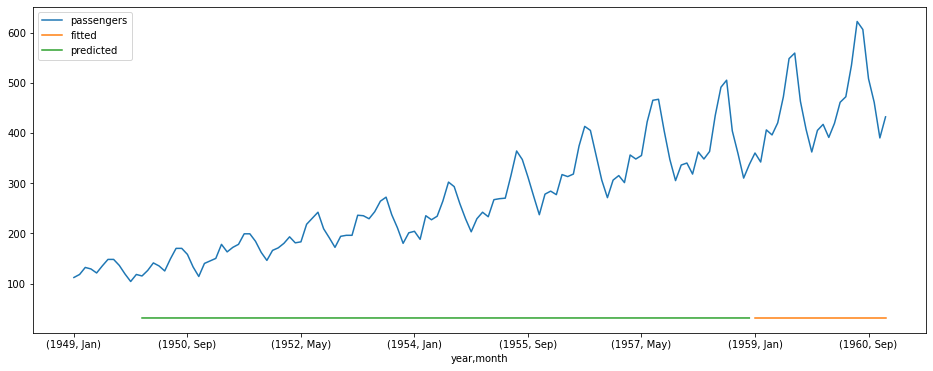

In [10]:
df_pred = df.copy()
df_pred['fitted'] = np.NaN
df_pred['predicted'] = np.NaN
df_pred.iloc[-TEST_DATA_SIZE:,1] = model.predict(X_test)
df_pred.iloc[WINDOW:-TEST_DATA_SIZE,2] =  model.predict(X_train)

df_pred.plot(figsize=(16,6))

## Save the model and upload 

We will save the model in SavedModel format and then upload it to Waylay. 

In [11]:
from waylay import WaylayClient, RestResponseError
import tempfile

waylay = WaylayClient.from_profile()

There are many other ways to create a SavedModel, for example using [Estimators](https://www.tensorflow.org/guide/estimator#savedmodels_from_estimators) or using a custom [Module](https://www.tensorflow.org/guide/saved_model#saving_a_custom_model), all follow the same flow to upload the model to Waylay. Just pass the directory where you saved your model to the SDK and we will do the rest.

In [19]:
# clean up existing model
import time
try:
    waylay.byoml.model.remove(MODEL_NAME)
    display(f'Removed: {MODEL_NAME}')
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'Model does not exist'; DELETE 'https://byoml-staging.waylay.io/models/retries-example')"

In [20]:
result = waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='tensorflow', 
    description='tensorflow example'
)

result

INFO:tensorflow:Assets written to: /var/folders/07/zn347xhn33z8m79l8xtz1hn80000gp/T/tmplfychimh/assets


{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'createdOn': '2021-08-26T12:42:37.897410+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.1',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'tensorflow example',
  'inputs': None,
  'outputs': None},
 'name': 'retries-example',
 'updatedOn': '2021-08-26T12:42:37.897442+00:00',
 'version': '1'}

After upload, it can take a few seconds before the model is available for execution.

This can be seen when by inspecting the `ready` property when retrieving the model.

In [21]:
try:
    result = waylay.byoml.model.get(MODEL_NAME)
    display(result)
except Exception as e:
    display(e)

{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'createdOn': '2021-08-26T12:42:37.849000+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.1',
 'metadata': {'description': 'tensorflow example',
  'inputs': None,
  'outputs': None},
 'name': 'retries-example',
 'ready': False,
 'supported_endpoints': [],
 'updatedBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'updatedOn': '2021-08-26T12:42:37.849000+00:00',
 'version': '1'}

For resources such as a BYOML model, you can poll until the deployment is ready by including the `retry_until_ready` flag.

In [23]:
try:
    result = waylay.byoml.model.get(MODEL_NAME, retry_until_ready=True)
    display(result)
except Exception as e:
    display(e)


TypeError("get() got an unexpected keyword argument 'retry_until_ready'")

When making predictions, retry handling will also wait until the model is ready:

In [29]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
    display(predictions[:3])
except Exception as e:
    display(e)
    

array([[31.3370075],
       [31.3370152],
       [31.3370113]])

You can provide additional parameters to influence the retry behaviour:
* `retry_attempts=20`   : Maximal number of retries.
* `retry_max_delay=120` : Maximal delay in seconds.
* `timeout`             : Maximal number of seconds that the client will wait for one attempt. This parameter is available on most Python SDK calls.

In [40]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy(), retry_attempts=1, retry_max_delay=1)
    display(predictions[:3])
except Exception as e:
    display(e)
    

waylay.service.byoml._exceptions.ByomlActionError('operation=server_error')

In [48]:
try:
    waylay.byoml.model.remove(MODEL_NAME)
except Exception as e:
    display(f'{e}')

"ByomlActionError(404: 'Model does not exist'; DELETE 'https://byoml-staging.waylay.io/models/retries-example')"

Retry behaviour won't be triggered by non-existing resources, but only on responses with specific HTTP status codes (`409`, `429`, `500`, `502`, `503`, `504`, `508`). The _NOT FOUND_ `404` error will just be forwarded to the user:


In [51]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
    display(predictions[:3])
except Exception as e:
    display(e)

array([[31.3370075],
       [31.3370152],
       [31.3370113]])

In [49]:
result = waylay.byoml.model.upload(
    model_name=MODEL_NAME, 
    trained_model=model, 
    framework='tensorflow', 
    description='tensorflow example',
    timeout=300
)

result

INFO:tensorflow:Assets written to: /var/folders/07/zn347xhn33z8m79l8xtz1hn80000gp/T/tmpk3_4x5u8/assets


{'createdBy': 'users/0476f99d-ac60-4f86-bc45-7215962754cd',
 'createdOn': '2021-08-26T13:04:43.527452+00:00',
 'description': 'tensorflow example',
 'framework': 'tensorflow',
 'framework_version': '2.1',
 'message': 'Model successfully uploaded',
 'metadata': {'description': 'tensorflow example',
  'inputs': None,
  'outputs': None},
 'name': 'retries-example',
 'updatedOn': '2021-08-26T13:04:43.527509+00:00',
 'version': '1'}

We immediately try prediction on the new model with a low `timeout=5` and `retry_attempts = 1`: this should fail as the endpoint will not be ready.

In [43]:
try:
    predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy(), timeout=5, retry_attempts = 1)
    display(predictions[:3])
except Exception as e:
    display(e)
    


waylay.service.byoml._exceptions.ByomlActionError('operation=not_found_error')

Calling without extra parameters should normally wait/retry long enough for succesfull results.

In [53]:
predictions = waylay.byoml.model.predict(MODEL_NAME, X_test.numpy())
display(predictions[:3])

24

In [24]:
waylay.byoml.model.remove(MODEL_NAME)

{'message': 'Model successfully deleted'}